In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
from bs4 import BeautifulSoup

In [2]:
from scipy.optimize import curve_fit as curve_fit
import datetime as dt
import matplotlib.pyplot as plt
import json
import folium 
import requests

In [3]:
from tqdm import tqdm
from tqdm import tnrange

#### Matplotlib Specs

In [4]:
default_text_size=10
font_times = {'family':'Arial'}

plt.rc('font', size=default_text_size)          # controls default text sizes
plt.rc('axes', titlesize=default_text_size)     # fontsize of the axes title
plt.rc('axes', labelsize=default_text_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=default_text_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=default_text_size)    # fontsize of the tick labels
plt.rc('figure', titlesize=default_text_size)  # fontsize of the figure title
plt.rc('font', **font_times)
plt.rc('figure', figsize=(10,8))
plt.rc('figure', facecolor='w')
plt.rc('legend', fontsize=10, frameon=False)
plt.rc('lines', linewidth=2)
lw = 2 #default line width
ms = 15

#### Load data
Data acquired from Kaggle dataset on BART daily ridership, sourced directly from BART 
https://www.kaggle.com/datasets/mrgeislinger/bartridership?select=date-hour-soo-dest-2021.csv

In [25]:
t2021 = pd.read_csv('BART_DATASET/date-hour-soo-dest-2021.csv', names=['Day', 'Hour', 'Origin', 'Destination', 'Trip Count'])
t2020 = pd.read_csv('BART_DATASET/date-hour-soo-dest-2020.csv', names=['Day', 'Hour', 'Origin', 'Destination', 'Trip Count'])
t2019 = pd.read_csv('BART_DATASET/date-hour-soo-dest-2019.csv', names=['Day', 'Hour', 'Origin', 'Destination', 'Trip Count'])
# t2018 = pd.read_csv('BART_DATASET/date-hour-soo-dest-2018.csv', names=['Day', 'Hour', 'Origin', 'Destination', 'Trip Count'])
# t2017 = pd.read_csv('BART_DATASET/date-hour-soo-dest-2017.csv', names=['Day', 'Hour', 'Origin', 'Destination', 'Trip Count'])
# t2016 = pd.read_csv('BART_DATASET/date-hour-soo-dest-2016.csv', names=['Day', 'Hour', 'Origin', 'Destination', 'Trip Count'])
# t2015 = pd.read_csv('BART_DATASET/date-hour-soo-dest-2015.csv', names=['Day', 'Hour', 'Origin', 'Destination', 'Trip Count'])
t2014 = pd.read_csv('BART_DATASET/date-hour-soo-dest-2014.csv', names=['Day', 'Hour', 'Origin', 'Destination', 'Trip Count'])

#### Obtaining Zipcodes, Cleaning Dataframes 
Only needs to be run once

In [6]:
# #webscraping to get zipcodes
# stat_names = pd.read_csv('BART_STATIONS_ABBREVIATIONS.txt', delimiter='\t')
# zips = pd.read_csv('bay_zipcodes.txt', delimiter='\t')

# zipcodes = []
# for name in stat_names['Abbr']:
#     URL = f'https://www.bart.gov/stations/{name}'
#     page = requests.get(URL)
#     soup = BeautifulSoup(page.content, 'html.parser')
#     for link in soup.find_all('a', href=True):
#         if '9' in link.text and ' ' not in (link.text)[-5:]:
#             zipcode = (link.text)[-5:]
#             try:
#                 int(zipcode)
#                 zipcodes.append(zipcode)
#             except ValueError: 
#                 pass
# stat_names['Zipcode'] = zipcodes

# up_names = []
# for s in stat_names['Abbr']:
#     up_names.append(s.upper())
# stat_names['Abbr'] = up_names

# stat_names.set_index('Abbr', inplace=True)

# #checking for missing values
# for df in [t2021, t2020, t2019, t2018, t2017, t2016, t2015, t2014]:
#     add_year(df)
    
# df_list = [t2021, t2020, t2019, t2018, t2017, t2016, t2015, t2014]

# for df in df_list: 
#     print(df.isnull().values.any())
# #No NaN values, interpolation not necessary 

# #making the full dataframe
# full_df = pd.concat([t2021, t2020, t2019, t2018, t2017, t2016, t2015, t2014])

# # full_df['Origin_Zipcode'] = np.zeros(len(full_df))
# # full_df['Destination_Zipcode'] = np.zeros(len(full_df))

# og_zip = []
# for i, station in enumerate(full_df.Origin): 
# #     full_df.iloc[i]['Origin_Zipcode'] = stat_names.loc[station]['Zipcode']
#     og_zip.append(stat_names.loc[station]['Zipcode'])
# full_df['Origin_Zipcode'] = og_zip

# dest_zip = []
# for i, station in enumerate(full_df.Destination):
# #     full_df.iloc[i]['Destination_Zipcode'] = stat_names.loc[station]['Zipcode']
#     dest_zip.append(stat_names.loc[station]['Zipcode'])
# full_df['Destination_Zipcode'] = dest_zip
# full_df.to_csv('BART_cleaned_updated_dataset.csv', index=False)

### Functions for Analysis

In [6]:
stat_names = pd.read_csv('BART_STATIONS_ABBREVIATIONS_ZIPCODES.txt', index_col='Abbr')
zip_dict = {i:stat_names['Zipcode'][i] for i in stat_names.index}
full_df = pd.read_csv('BART_cleaned_updated_dataset.csv', index_col='Day')
# colors = plt.cm.seismic(np.linspace(0.2,0.4,2))

def add_year(df):
    """
    Add year column to BART df 
    """
    if 'Year' not in df.columns:
        df['Day'] = pd.to_datetime(df['Day'])
        df.set_index('Day', inplace=True)
        year = (df.index).year
        df['Year'] = year
    

def add_zip(df):
    """
    Add zipcodes to BART df to match station names
    """
    global zip_dict
    if 'Origin_Zipcode' not in df.columns: 
        og_zip = []
        for station in tqdm(df.Origin): 
            og_zip.append(zip_dict[station])
        df['Origin_Zipcode'] = og_zip

        dest_zip = []
        for station in tqdm(df.Destination):
            dest_zip.append(zip_dict[station])
        df['Destination_Zipcode'] = dest_zip
    
def perc_change(df1, df2, groupby:bool, origin:bool=True):
    """
    Calculate the percent change in total ridership at specific zipcodes/origin stations between two years  
    
    Inputs: df1 (old) df2 (new) dataframes
            groupby: grouping by stations (True) or zipcodes (False)
            origin: bool, default True, True: looking at origin stations/zipcodes, 
                                        False: looking at destination stations/zipcodes
    Outputs: % change in total ridership 
    """
    global zip_dict
    add_year(df1)
    add_year(df2)
    add_zip(df1)
    add_zip(df2)
    if groupby & origin: #groupby origin stations
        col = 'Origin'
    elif groupby and not origin: #groupby destination stations
        col = 'Destination'
    elif not groupby and origin: #groupby origin zipcodes
        col = 'Origin_Zipcode'
    elif not groupby and not origin: #groupby destination zipcodes
        col = 'Destination_Zipcode'
    
    if df2['Year'][0] == '2020' and df1 is not t2021: 
        df2 = df2[df2['Origin'].isin(set(df2['Origin'].unique()).difference(['BERY', 'MLPT']))]
        if set(df1['Origin'].unique()).intersection(['BERY', 'MLPT']) != set():
            df1 = df1[df1['Origin'].isin(set(df2['Origin'].unique()).difference(['BERY', 'MLPT']))]
    elif df1['Year'][0] == '2020':
        df1 = df1[df1['Origin'].isin(set(df1['Origin'].unique()).difference(['BERY', 'MLPT']))]
        df2 = df2[df2['Origin'].isin(set(df2['Origin'].unique()).difference(['BERY', 'MLPT']))]
            
        
    
    old_sums = df1.groupby(col).sum().sort_values(by='Trip Count', ascending=False)['Trip Count']
    new_sums = df2.groupby(col).sum().sort_values(by = 'Trip Count', ascending = False)['Trip Count']
#     if df1['Year'][0] == '2020':
#         old_sums[zip_dict['BERY']] = int(old_sums[zip_dict['BERY']] * 1.48 )
#         old_sums[zip_dict['MLPT']] = int(old_sums[zip_dict['MLPT']] * 1.48 )
#     try: 
#         if df1 is t2014 and groupby: 
#             del old_sums['OAKL']
#             del old_sums[zip_dict['OAKL']]
#     except NameError:
#         pass 
    
#     try: 
#         if df2 in [t2020, t2021] and not groupby: 
#             del new_sums[zip_dict['BERY']]
#             del new_sums[zip_dict['MLPT']]
#         elif df2 in [t2020, t2021] and groupby: 
#             del new_sums['BERY']
#             del new_sums['MLPT']
#         elif df1 is t2020 and groupby: 
#             del old_sums['BERY']
#             del old_sums['MLPT']
#         elif df1 is t2021 and not groupby: 
#             del old_sums[zip_dict['BERY']]
#             del old_sums[zip_dict['MLPT']]
#     except NameError:
#         pass 
    
    new_sums = new_sums.reindex(old_sums.index)
    
    diff_df = pd.DataFrame([])
    diff_df[col] = old_sums.index
    name = '%change ' + str(df1['Year'][0]) + 'to ' + str(df2['Year'][0])
    diff_df[name] = ((new_sums - old_sums)/old_sums).values * 100
    diff_df = diff_df.sort_values(by=name, ascending=False)
    return diff_df, old_sums, new_sums

def growing_areas(df1, df2, groupby:bool, origin:bool=True, plot=True):
    """
    Find stations / zipcodes with growth (positive percent change) between different years
    Inputs: df1 (old) df2 (new) dataframes
            groupby: grouping by stations (True) or zipcodes (False)
            origin: True/False, true: looking at origin stations, false: looking at destination stations
            plot: default True, produce histogram
    Outputs: Dataframe of stations / zipcodes with growth 
    """
    diff_df, old_sums, new_sums = perc_change(df1, df2, groupby, origin)
    yr1 = str(df1['Year'][0])
    yr2 = str(df2['Year'][0])
    name = '%change ' + yr1 + 'to ' + yr2
    
    growth = diff_df[diff_df[name] >= 0]
    growth[yr1] = [old_sums[i] for i in growth[growth.columns[0]]]
    growth[yr2] = [new_sums[i] for i in growth[growth.columns[0]]]
    
    if plot: 
        x = (np.arange(0, len(growth.index)*2.5, 2.5))
        width = 0.5
        plt.figure(figsize=(7.5,7.5))
        plt.bar(x - width/2, growth[yr1].values, width, label=yr1, color=colors[0])
        plt.bar(x + width/2, growth[yr2].values, width, label=yr2, color=colors[1])
        plt.xticks(x, list(growth[growth.columns[0]]), size=15);
        plt.yticks(size=15);
        plt.legend(fontsize=20)
        plt.xlabel(diff_df.columns[0], fontsize=15)
        plt.ylabel('Trip Counts', fontsize=20)
    return growth
    
def NormalizeData(data):
    """
    Inputs: data (array, list, pandas Series)
    Outputs: Input data normalized to [0,1]
    """
    return (data - np.min(data)) / (np.max(data) - np.min(data))    

def yearly_plot(df1, df2, groupby:bool, origin:bool=True):
    """
    Plot ridership vs. year for year of df1 to year of df2
    Inputs: df1 (old) df2 (new) dataframes
            groupby: grouping by stations (True) or zipcodes (False)
            origin: True/False, true: looking at origin stations, false: looking at destination stations
            plot: default True, produce histogram
    """
    
    global full_df
    growth = growing_areas(df1, df2, groupby, origin, plot=False)
    plot_df = full_df.drop(columns = ['Year', 'Hour'])
    
    if groupby & origin: #groupby origin stations
        col = 'Origin'
    elif groupby and not origin: #groupby destination stations
        col = 'Destination'
    elif not groupby and origin: #groupby origin zipcodes
        col = 'Origin_Zipcode'
    elif not groupby and not origin: #groupby destination zipcodes
        col = 'Destination_Zipcode'
    plot_df = full_df.drop(columns = ['Year', 'Hour'])
    plot_df = plot_df[plot_df[col].isin(growth[col])]
    plot_df = plot_df.groupby([col, 'Day']).sum()
    plot_df = plot_df['Trip Count'].unstack(level=0)
    plot_df = plot_df.apply(func=NormalizeData)
    plot_df.plot(colormap='seismic', subplots=True, sharex=True, legend=True, sharey=True)
    plt.xticks(size=15);
    plt.yticks(size=15);
    plt.legend(fontsize=15)
    plt.xlabel(col, fontsize=15)
    plt.ylabel('Trip Counts', fontsize=15)
    return plot_df

In [7]:
import datetime as dt

def linear(x, m, b):
    """
    Linear function for curve_fitting 
    Output: y = m*x + b
    """
    return m*x + b
def growth_rate():
    """ 
    Calculate the growth rate of each zipcode in the 2021 dataset 
    Growth rate defined as the slope of the line fit to a plot of the ridership vs. time 
    """
    add_year(t2021)
    add_zip(t2021)
    
    df = t2021[t2021.index > '2021-05-31']
    df.index = pd.to_datetime(df.index)
    df['Ordinal_Time'] = df.index.map(dt.datetime.toordinal)
    df = df.groupby(['Origin_Zipcode', 'Ordinal_Time']).sum()['Trip Count'].unstack(level=0)
    
    m_arr = []
    b_arr = []
    m_err_arr = []
    b_err_arr = []
    for col in df.columns:
        temp = df[col].dropna()
        x = list(temp.index)
        y = temp.values
        popt, pcov = curve_fit(linear, x, y)
        perr = np.sqrt(np.diag(pcov))
        m, b = popt
        m_arr.append(m)
        b_arr.append(b)
        m_err_arr.append(perr[0])
        b_err_arr.append(perr[1])
    
    fit_df = pd.DataFrame({'Origin_Zipcode':df.columns, 'Slope(trip_per_day)':m_arr, 'intercept':b_arr,
                      'slope_err':m_err_arr, 'intercept_err':b_err_arr})
    return fit_df

### Exploratory Data Analysis

#### how did ridership change before/after June 2021 (vaccines out)

In [8]:
fit_df = growth_rate()
avg = fit_df['Slope(trip_per_day)'].mean()
std = fit_df['Slope(trip_per_day)'].std()

100%|██████████| 6598064/6598064 [00:03<00:00, 1763654.41it/s]
<ipython-input-7-6e164fadc0bd>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ordinal_Time'] = df.index.map(dt.datetime.toordinal)


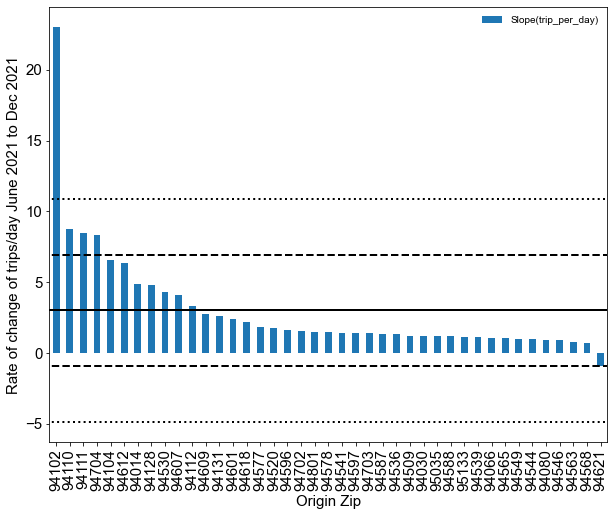

In [9]:
fit_df.sort_values(by='Slope(trip_per_day)', ascending=False).plot.bar(x='Origin_Zipcode', y='Slope(trip_per_day)')
plt.xticks(size=15);
plt.yticks(size=15);
plt.xlabel('Origin Zip', fontsize=15)
plt.ylabel('Rate of change of trips/day June 2021 to Dec 2021',fontsize=15)
plt.hlines(avg, -100,100, 'k')
plt.hlines(avg + std, -100,100, 'k', linestyles='--')
plt.hlines(avg + 2*std, -100,100, 'k', linestyles=':')
plt.hlines(avg - std, -100,100, 'k', linestyles='--')
plt.hlines(avg -2* std, -100,100, 'k', linestyles=':')

#### Which stations experienced growth between 2020 and 2021?  

<ipython-input-6-1b8b705e6193>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  growth[yr1] = [old_sums[i] for i in growth[growth.columns[0]]]
<ipython-input-6-1b8b705e6193>:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  growth[yr2] = [new_sums[i] for i in growth[growth.columns[0]]]


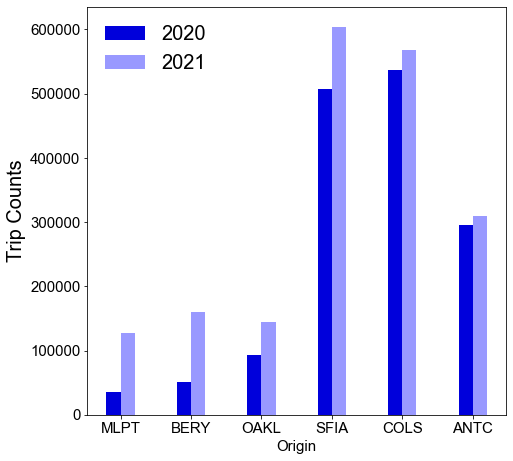

In [12]:
colors = plt.cm.seismic(np.linspace(0.2,0.4,2))
growth_df = growing_areas(t2020, t2021, True, True)

In [13]:
add_year(t2019)
add_year(t2020)
add_zip(t2020)
add_zip(t2020)
add_year(t2021)
add_zip(t2021)

#### Comparing March-Dec 2020 w. Jan-Dec 2021

In [14]:
covid2020 = t2020[t2020.index > '2020-02-29']

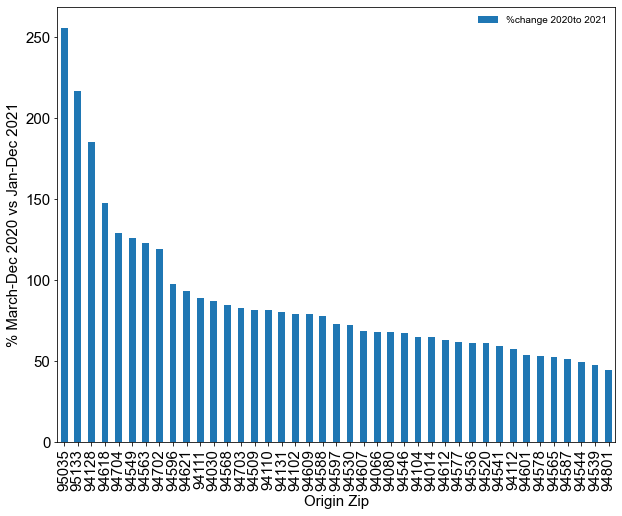

In [15]:
diff_df, old_sums, new_sums = perc_change(covid2020, t2021, False, True)
diff_df.plot.bar('Origin_Zipcode')
plt.xlabel('Origin Zip', fontsize=15)
plt.ylabel('% March-Dec 2020 vs Jan-Dec 2021',fontsize=15)
plt.xticks(size=15);
plt.yticks(size=15);

#### Top growing stations, 2020 to 2021
Notice ANTC, BERY, MLPT are top growers because did not exist in early 2020

<ipython-input-6-1b8b705e6193>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  growth[yr1] = [old_sums[i] for i in growth[growth.columns[0]]]
<ipython-input-6-1b8b705e6193>:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  growth[yr2] = [new_sums[i] for i in growth[growth.columns[0]]]
/Applications/miniconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


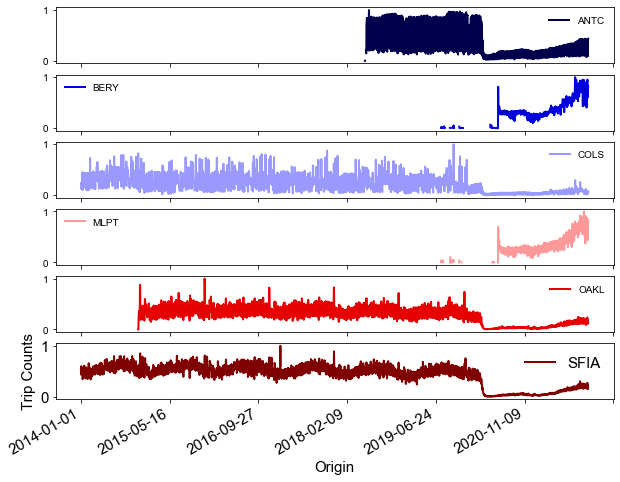

In [17]:
plot_df = yearly_plot(t2020, t2021, True, True)

#### just looking at 2021

In [18]:
growth21 = t2021[t2021['Origin'].isin(growth_df['Origin'])]
del growth21['Hour']
del growth21['Year']
del growth21['Destination']

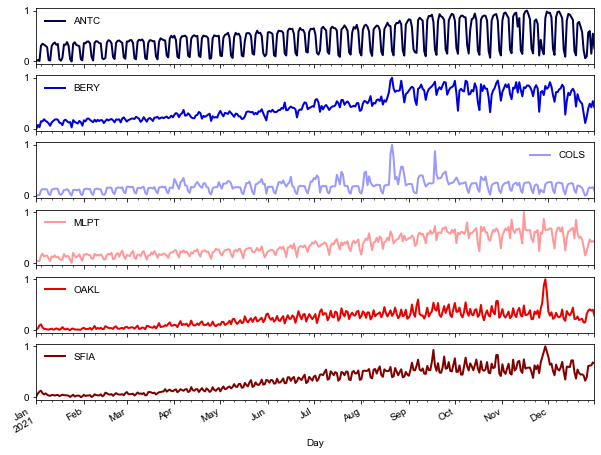

In [21]:
df = growth21.groupby(['Origin', 'Day']).sum().unstack(level=0)['Trip Count']
df = df.apply(func=NormalizeData)
df.plot(colormap='seismic', subplots=True, sharex=True, legend=True);

#### raw data, one plot

Text(0, 0.5, 'Trip Counts')

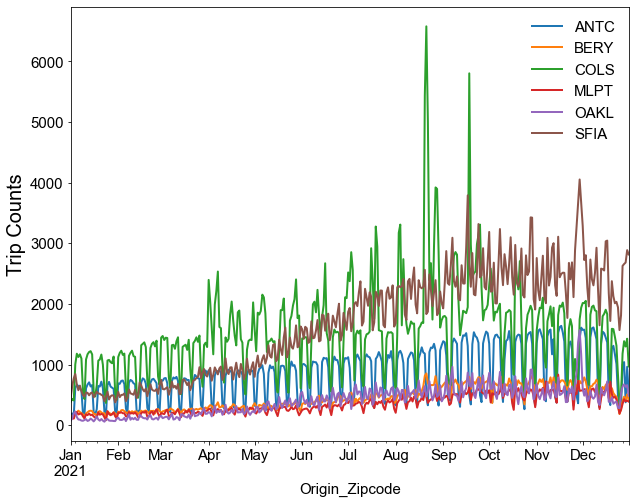

In [23]:
df = growth21.groupby(['Origin', 'Day']).sum()
df.unstack(level=0)['Trip Count'].plot()
plt.xticks(size=15);
plt.yticks(size=15);
plt.legend(fontsize=15)
plt.xlabel(diff_df.columns[0], fontsize=15)
plt.ylabel('Trip Counts', fontsize=20)

In [26]:
add_zip(t2014)
t2014_sums = t2014.groupby('Origin_Zipcode').sum().sort_values(by='Trip Count', ascending=False)['Trip Count']
t2019_sums = t2019.groupby('Origin_Zipcode').sum().sort_values(by='Trip Count', ascending=False)['Trip Count']
t2019_sums = t2019_sums.reindex(t2014_sums.index)

100%|██████████| 9891771/9891771 [00:05<00:00, 1963499.91it/s]


#### % change 2014-2019 (all pre-covid times)

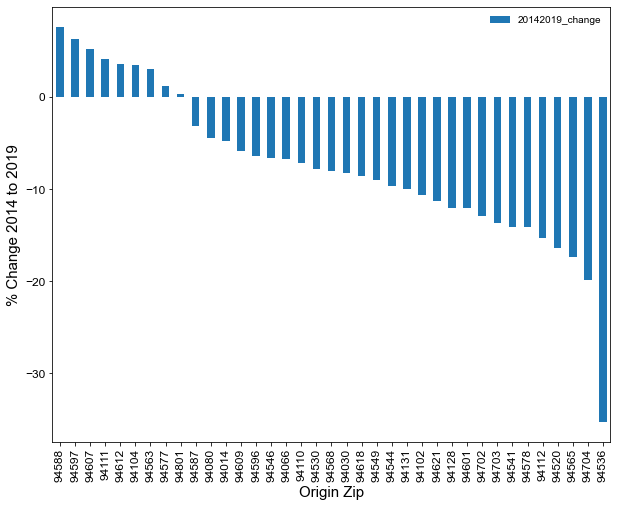

In [27]:
t2014_t2019 = pd.DataFrame([])
t2014_t2019['Origin'] = t2014_sums.index
t2014_t2019['20142019_change'] = ((t2019_sums - t2014_sums)/t2014_sums).values * 100

t2014_t2019 = t2014_t2019.sort_values(by='20142019_change', ascending=False)
t2014_t2019.plot.bar('Origin')
plt.xlabel('Origin Zip', fontsize=15)
plt.ylabel('% Change 2014 to 2019',fontsize=15)
plt.xticks(size=12);
plt.yticks(size=12);

In [28]:
incr_stats = t2014_t2019[t2014_t2019['20142019_change'] >= 0]
incr_stats['2019'] = [t2019_sums[i] for i in incr_stats['Origin']]
incr_stats['2014'] = [t2014_sums[i] for i in incr_stats['Origin']]

<ipython-input-28-a7c909a65892>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incr_stats['2019'] = [t2019_sums[i] for i in incr_stats['Origin']]
<ipython-input-28-a7c909a65892>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incr_stats['2014'] = [t2014_sums[i] for i in incr_stats['Origin']]


#### growing zipcodes, 2014 t0 2019

Text(0, 0.5, 'Trip Counts')

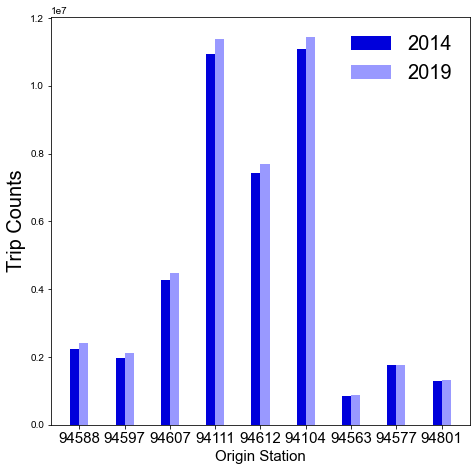

In [29]:
df = incr_stats
x = (np.arange(0, len(df.index)*2.5, 2.5))
# x = np.arange(len(t2019_sums.index))
width = 0.5
plt.figure(figsize=(7.5,7.5))
plt.bar(x - width/2, incr_stats['2014'].values, width, label='2014', color=colors[0])
plt.bar(x + width/2, incr_stats['2019'].values, width, label='2019', color=colors[1])
plt.xticks(x, list(df['Origin']), size=15);
plt.legend(fontsize=20)
plt.xlabel('Origin Station', fontsize=15)
plt.ylabel('Trip Counts', fontsize=20)

# plt.bar(t2015_sums.index, t2015_sums.values)
# plt.bar(t2019_sums.index + 10, t2019_sums.values)